In [1]:
from typing import Any
import numpy as np
import pandas as pd
from lisatools.diagnostic import snr as snr_func
from lisatools.diagnostic import plot_covariance_contour, plot_covariance_corner
from lisatools.sensitivity import get_sensitivity, A1TDISens
from lisatools.detector import scirdv1, Orbits, DefaultOrbits, LISAModel, Space2050Model
from lisatools.utils.constants import *
from lisatools.sources import CalculationController, BBHCalculatorController, GBCalculatorController, EMRICalculatorController
from lisatools.sources.emri import EMRIAETWaveform
from lisatools.sources.bbh import BBHSNRWaveform
from lisatools.sources.gb import GBAETWaveform

from abc import ABC
from typing import Union, Tuple
import matplotlib.pyplot as plt
%matplotlib inline

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


## Define mission characteristics

In [2]:
missions = {}

def get_df(Tobs: float, dt: float) -> float:
    Nobs = int(Tobs / dt)
    Tobs = Nobs * dt
    df = 1 / Tobs
    return df


In [3]:
lisa_orbits = Orbits("../space_2050_models/lisa_orbits.h5", armlength=2.5e9)

lisa = Space2050Model(
    "../space_2050_models/LISA_sensitivity_AET.csv", lisa_orbits, "lisa"
)

psd_kwargs = dict(
    # stochastic_params=(10.0 * YRSID_SI,),
)

missions["lisa"] = dict(
    model=lisa,
    psd_kwargs=psd_kwargs,
    Tobs=YRSID_SI, 
    dt=10.0
)

In [4]:

lisamax_orbits = Orbits("../space_2050_models/lisamax_orbits.h5", armlength=2.59e+11)
lisa_max = Space2050Model(
    "../space_2050_models/LISAmax_sensitivity_AET.csv", lisamax_orbits, "lisa_max"
)
psd_kwargs = dict(
    # stochastic_params=(10.0 * YRSID_SI,),
)
missions["lisamax"] = dict(
    model=lisa_max,
    psd_kwargs=psd_kwargs,
    Tobs=YRSID_SI, 
    dt=20.0
)

muares = Space2050Model(
    "../space_2050_models/muAres_sensitivity_AET.csv", lisamax_orbits, "muares"
)
psd_kwargs = dict(
    # stochastic_params=(10.0 * YRSID_SI,),
)
missions["muares"] = dict(
    model=muares,
    psd_kwargs=psd_kwargs,
    Tobs=YRSID_SI, 
    dt=20.0
)

In [5]:
deci_orbits = Orbits("../space_2050_models/deci_orbits.h5", armlength=1e8)

deci_cons = Space2050Model(
    "../space_2050_models/DO_conservative_sensitivity_AET.csv", deci_orbits, "deci_cons"
)

psd_kwargs = dict(
    # stochastic_params=(10.0 * YRSID_SI,),
)

missions["deci_cons"] = dict(
    model=deci_cons,
    psd_kwargs=psd_kwargs,
    Tobs=YRSID_SI / 2.0, 
    dt=0.5
)

deci_opt = Space2050Model(
    "../space_2050_models/DO_optimal_sensitivity_AET.csv", deci_orbits, "deci_opt"
)

psd_kwargs = dict(
    # stochastic_params=(10.0 * YRSID_SI,),
)

missions["deci_opt"] = dict(
    model=deci_opt,
    psd_kwargs=psd_kwargs,
    Tobs=YRSID_SI / 2.0, 
    dt=0.5
)

## Diagnostics

Setup all snr calculators

In [6]:
for mission in missions:
    print(mission)
    orbits_here = missions[mission]["model"].orbits
    # black hole generator
    bbh = BBHSNRWaveform(response_kwargs=dict(TDItag="AET", orbits=orbits_here, tdi2=True))

    missions[mission]["bbh"] = BBHCalculatorController(
        bbh, 
        missions[mission]["model"],
        missions[mission]["psd_kwargs"], 
        missions[mission]["Tobs"] / YRSID_SI,
        missions[mission]["dt"],
        psd=A1TDISens
    )
    
    # gb generator
    gb = GBAETWaveform(orbits=orbits_here)

    missions[mission]["gb"] = GBCalculatorController(
        gb, 
        missions[mission]["model"], 
        missions[mission]["psd_kwargs"], 
        missions[mission]["Tobs"] / YRSID_SI,
        missions[mission]["dt"],
        psd=A1TDISens
    )

    # emri generator
    emri = EMRIAETWaveform(
        T=missions[mission]["Tobs"] / YRSID_SI,  # in sec
        dt=missions[mission]["dt"], 
        response_kwargs=dict(tdi="2nd generation", orbits=orbits_here)
    )

    missions[mission]["emri"] = EMRICalculatorController(
        emri, missions[mission]["model"], 
        missions[mission]["psd_kwargs"], 
        missions[mission]["Tobs"] / YRSID_SI,  # in sec
        missions[mission]["dt"],
        psd=A1TDISens
    )
    


lisa


lisamax
muares
deci_cons
deci_opt


### MBHBs

lisa 1774.9461023621702
lisamax 235877.55577486474
muares 7201144.783825578
deci_cons 78.8169300806267
deci_opt 78.88191028341761


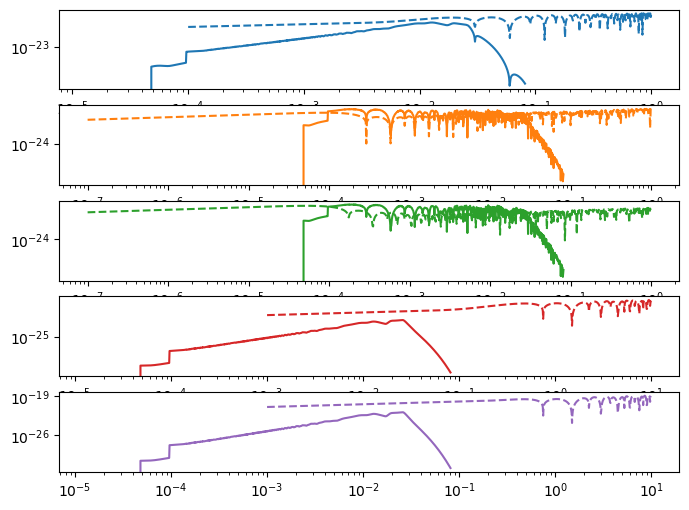

In [7]:
# in SSB

f_ref = 0.0  # let phenom codes set f_ref -> fmax = max(f^2A(f))
phi_ref = 0.5  # phase at f_ref
m1 = 1e6
m2 = 5e5
M = m1 + m2
q = m2 / m1  # m2 less than m1
a1 = 0.2
a2 = 0.4
dist = 10.0 * PC_SI * 1e9  # in m
inc = np.pi / 3.0
beta = np.pi / 4.0  # ecliptic latitude
lam = np.pi / 5.0  # ecliptic longitude
psi = np.pi / 6.0  # polarization angle

t_ref = YRSID_SI * 0.25  # (in the SSB reference frame)

mbh_injection_params = np.array(
    [m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref]
)
fig, ax = plt.subplots(len(list(missions.keys())), 1, figsize=(8, 6))
for i, (name, mission) in enumerate(missions.items()):
    fn = mission["model"].fn
    print(name, mission["bbh"].get_snr(*mbh_injection_params))
    Sn = get_sensitivity(fn, model=mission["model"], sens_fn=A1TDISens, **mission["psd_kwargs"])
    ax[i].loglog(mission["bbh"].f_arr, mission["bbh"].f_arr * np.abs(mission["bbh"].last_output[0]), c=f"C{i}")
    df = get_df(mission["Tobs"], mission["dt"])
    ax[i].loglog(fn, np.sqrt(fn) * (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")


In [8]:
# example with last mission
scaled_inj_params, cov = mission["bbh"].get_cov(
    *mbh_injection_params,
    precision=True,
    more_accurate=False,
    eps=1e-9,
    deriv_inds=None,
)


/Users/mlkatz1/miniconda3/envs/test_2050_env/lib/python3.12/site-packages/lisatools/diagnostic.py:686: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samp = np.random.multivariate_normal(params, cov, size=nsamp)


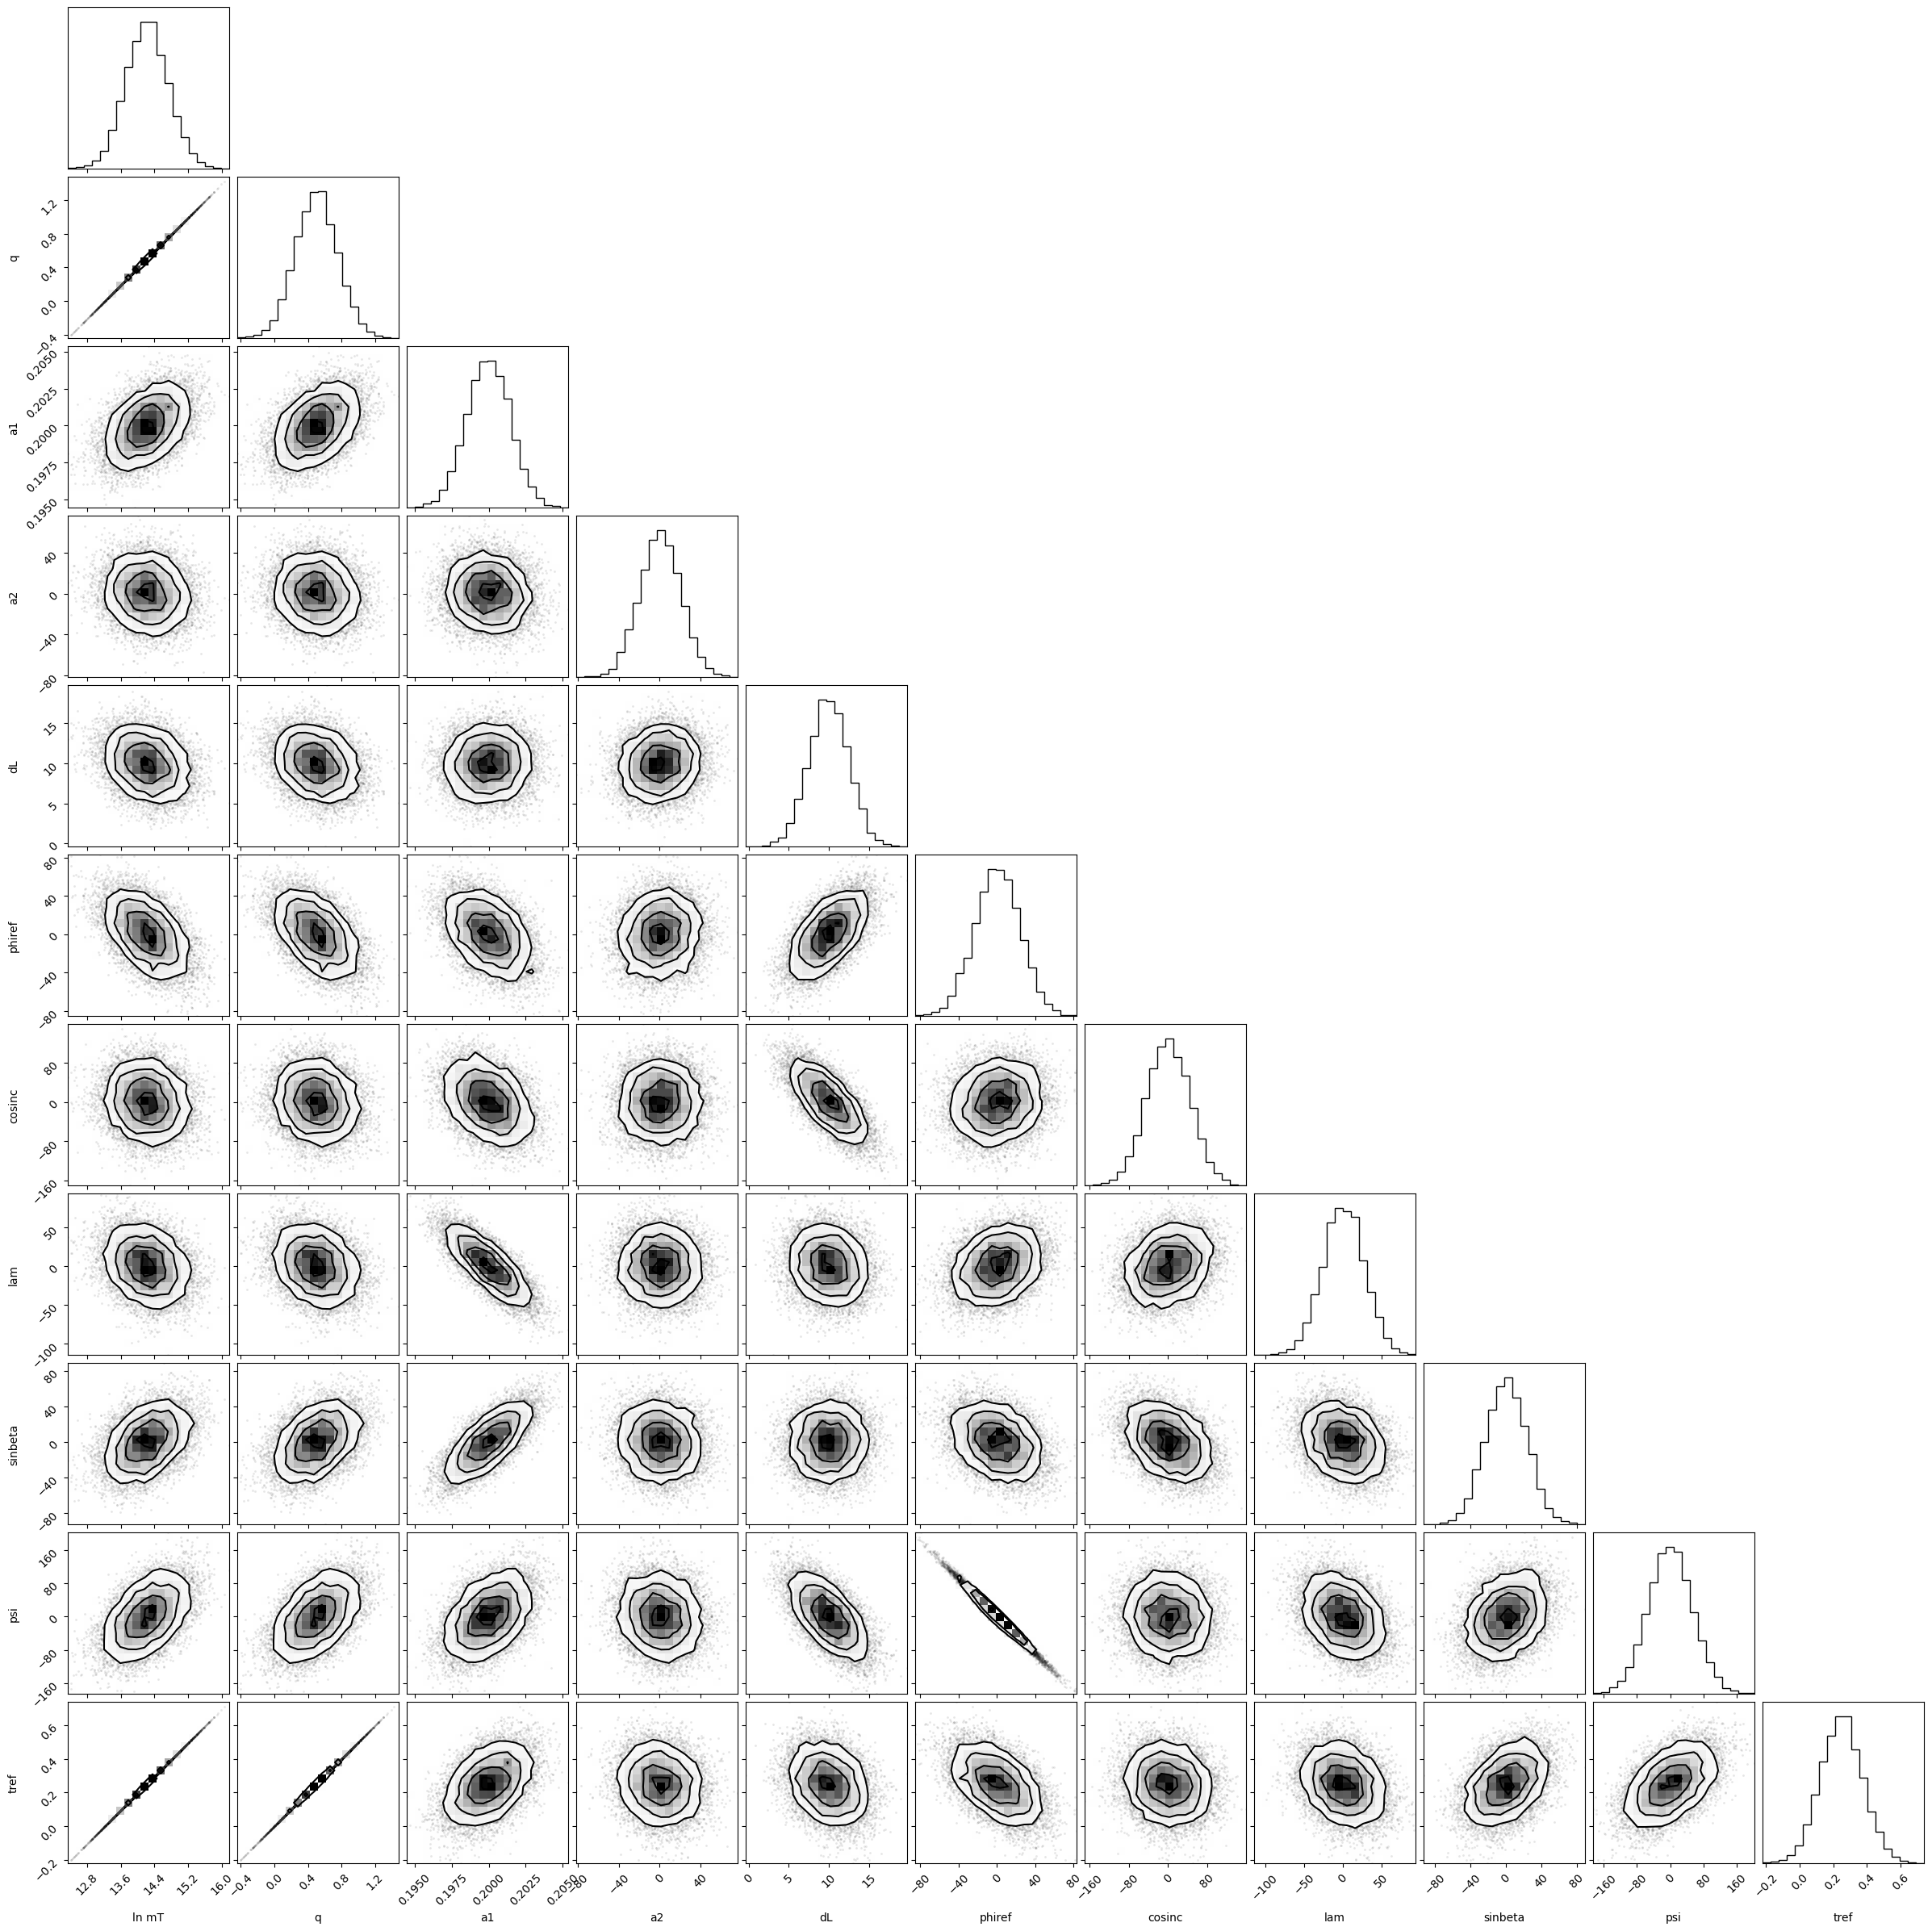

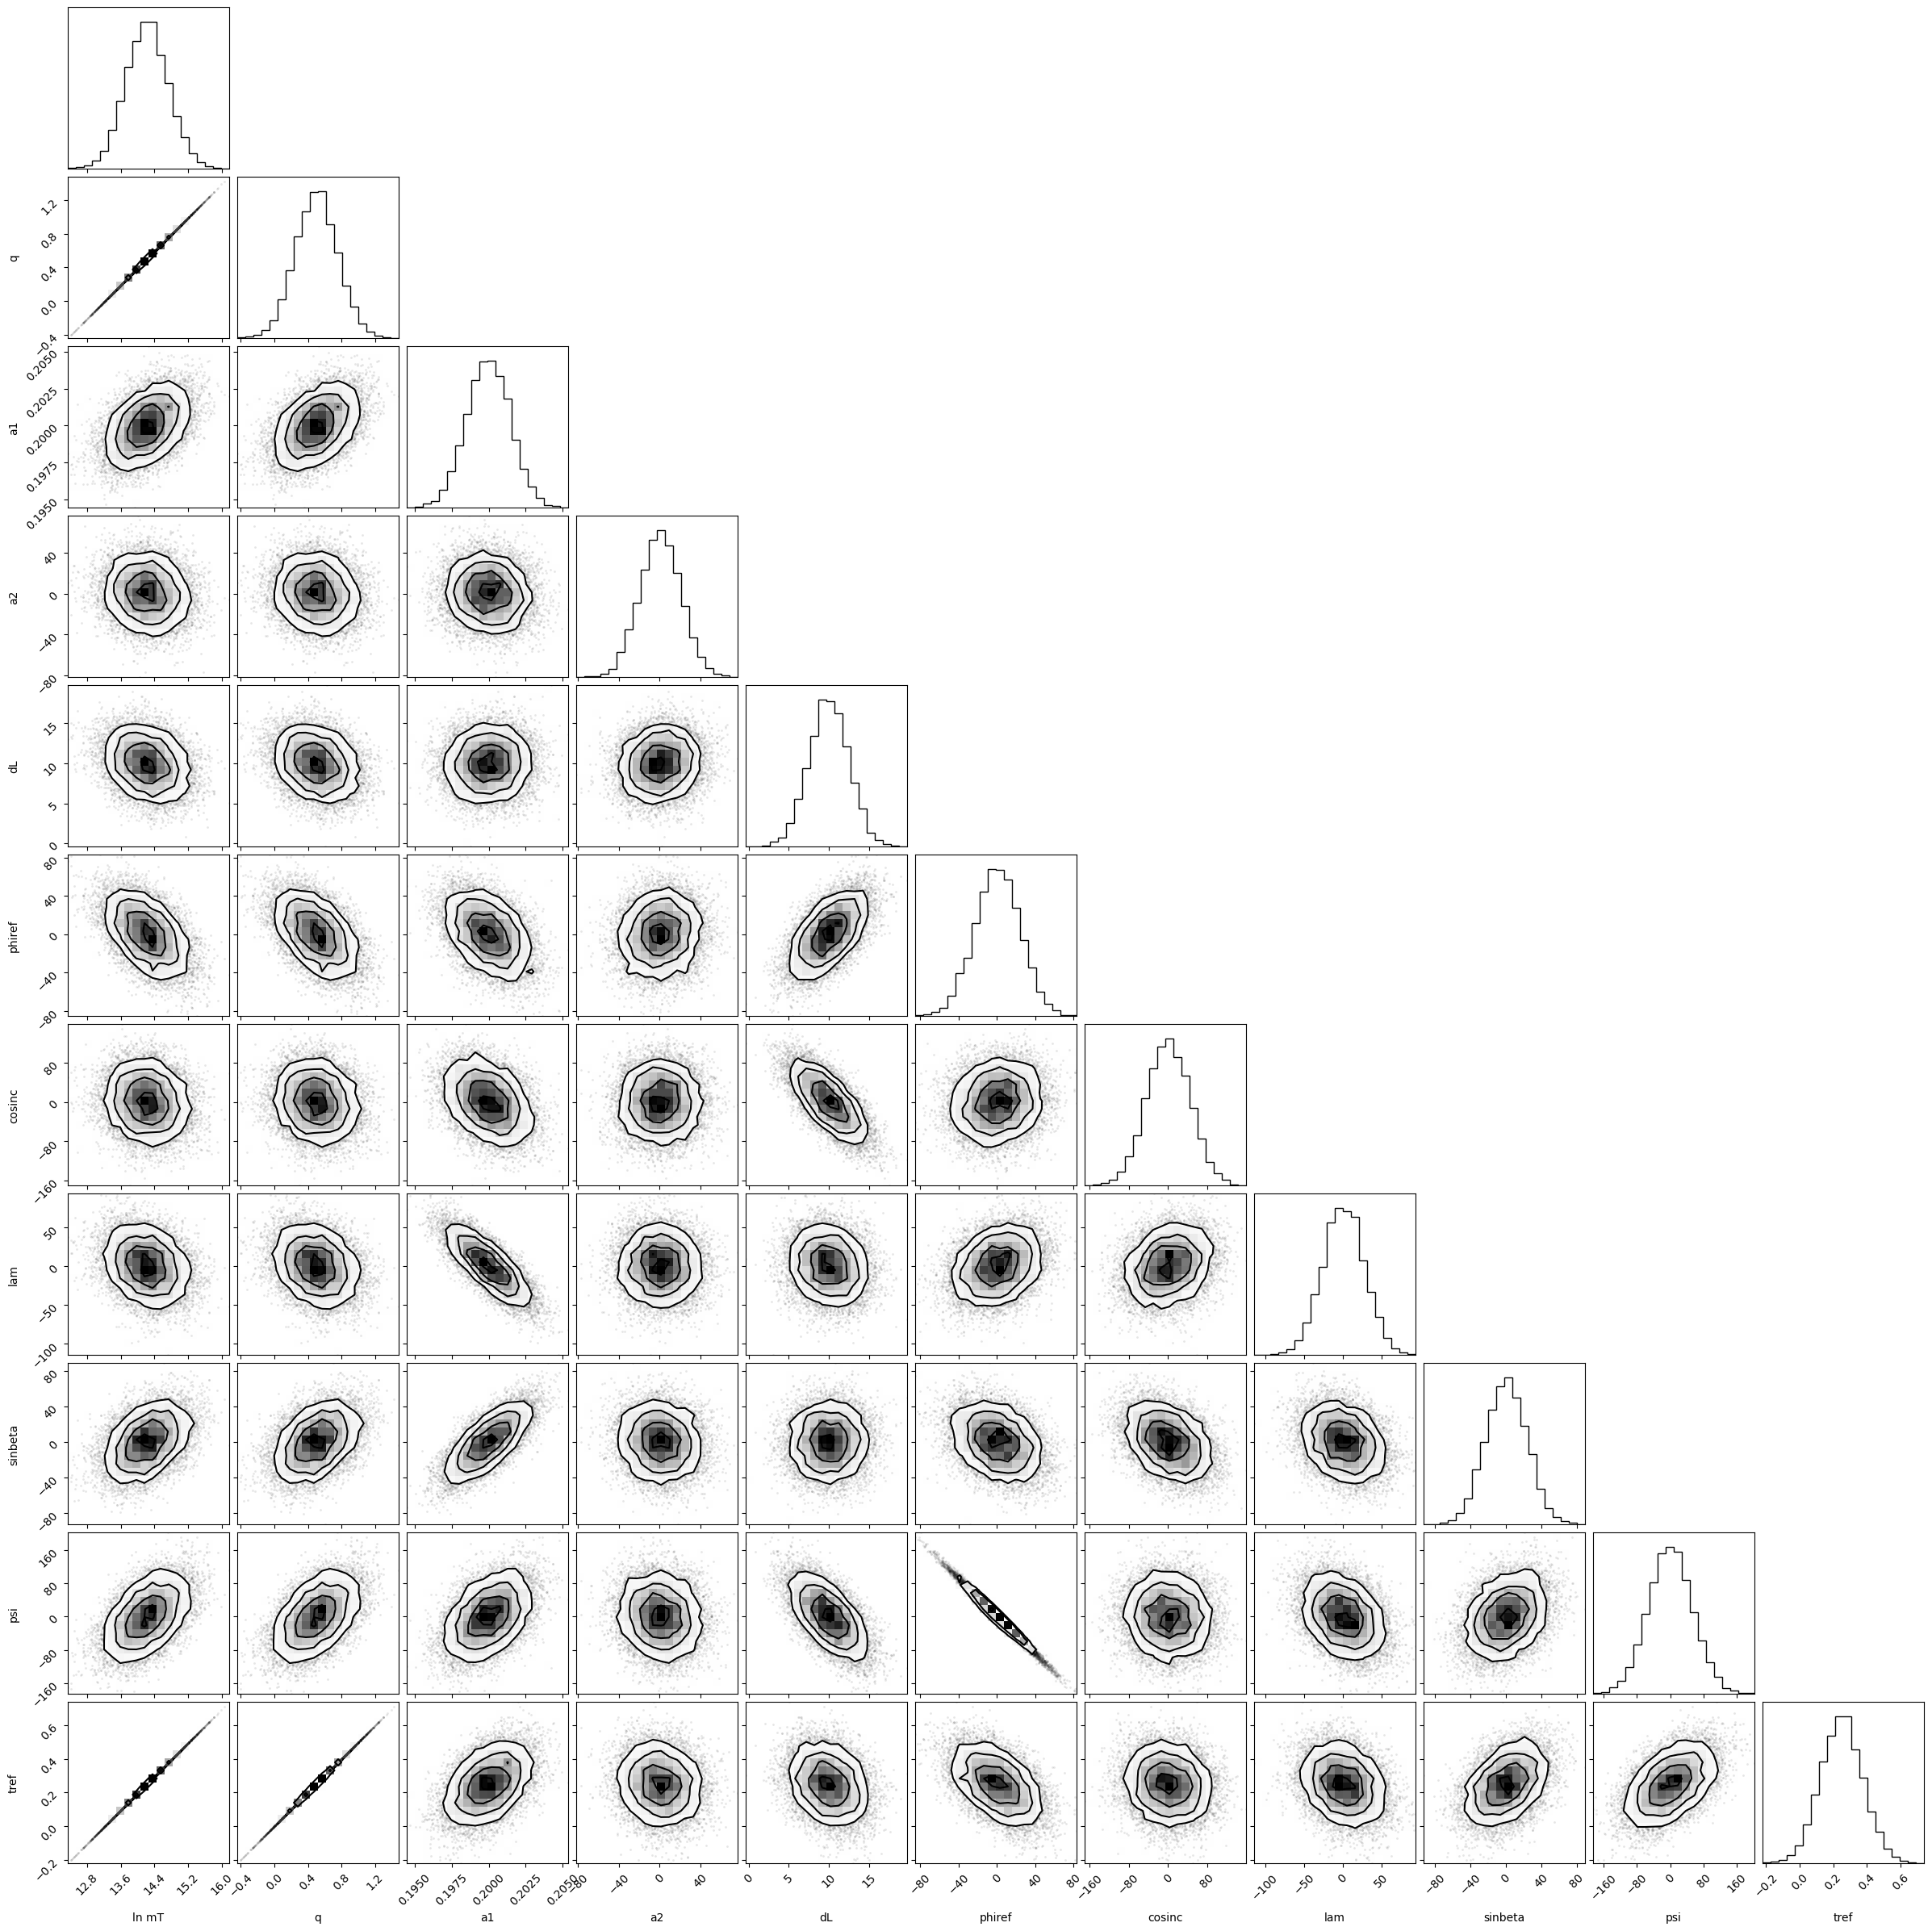

In [9]:
labels=["ln mT", "q", "a1", "a2", "dL", "phiref", "cosinc", "lam", "sinbeta", "psi", "tref"]
plot_covariance_corner(scaled_inj_params, cov, labels=labels, nsamp=10000)

### GBs

lisa 55.39699987183522
lisamax 2894.8960441386107
muares 12136.820893219368
deci_cons 0.3516139964951968
deci_opt 0.3516143943890647


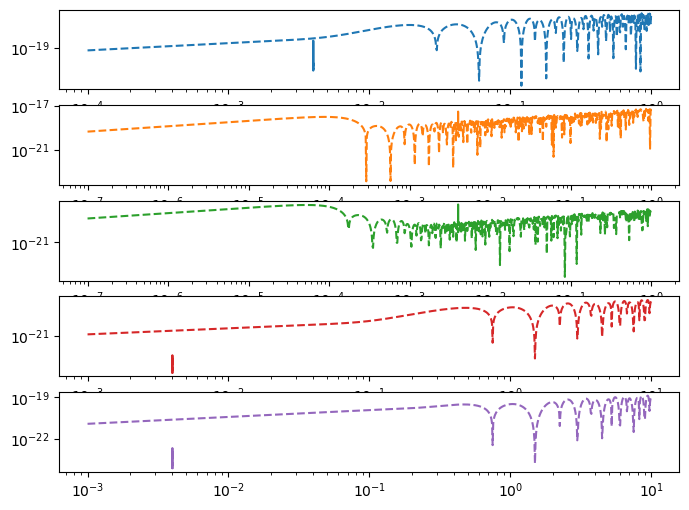

In [10]:
amp = 1e-22
f0 = 4e-3
fdot = 1e-18
fddot = 0.0
phi0 = 0.5
inc = 0.2
psi = 0.6
lam = 0.9
beta = -0.2
    
gb_injection_params = np.array([amp, f0, fdot, fddot, phi0, inc, psi, lam, beta])
fig, ax = plt.subplots(len(list(missions.keys())), 1, figsize=(8, 6))
for i, (name, mission) in enumerate(missions.items()):
    fn = mission["model"].fn
    print(name, mission["gb"].get_snr(*gb_injection_params))
    Sn = get_sensitivity(fn, model=mission["model"], sens_fn=A1TDISens, **mission["psd_kwargs"])
    ax[i].loglog(mission["gb"].f_arr, mission["gb"].f_arr * np.abs(mission["gb"].last_output[0]), c=f"C{i}")
    df = get_df(mission["Tobs"], mission["dt"])
    ax[i].loglog(fn, np.sqrt(fn) * (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")

In [11]:
scaled_inj_params, cov = mission["gb"].get_cov(
    *gb_injection_params,
    precision=True,
    more_accurate=False,
    eps=1e-11,
    deriv_inds=None,
)

/Users/mlkatz1/miniconda3/envs/test_2050_env/lib/python3.12/site-packages/lisatools/diagnostic.py:686: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samp = np.random.multivariate_normal(params, cov, size=nsamp)


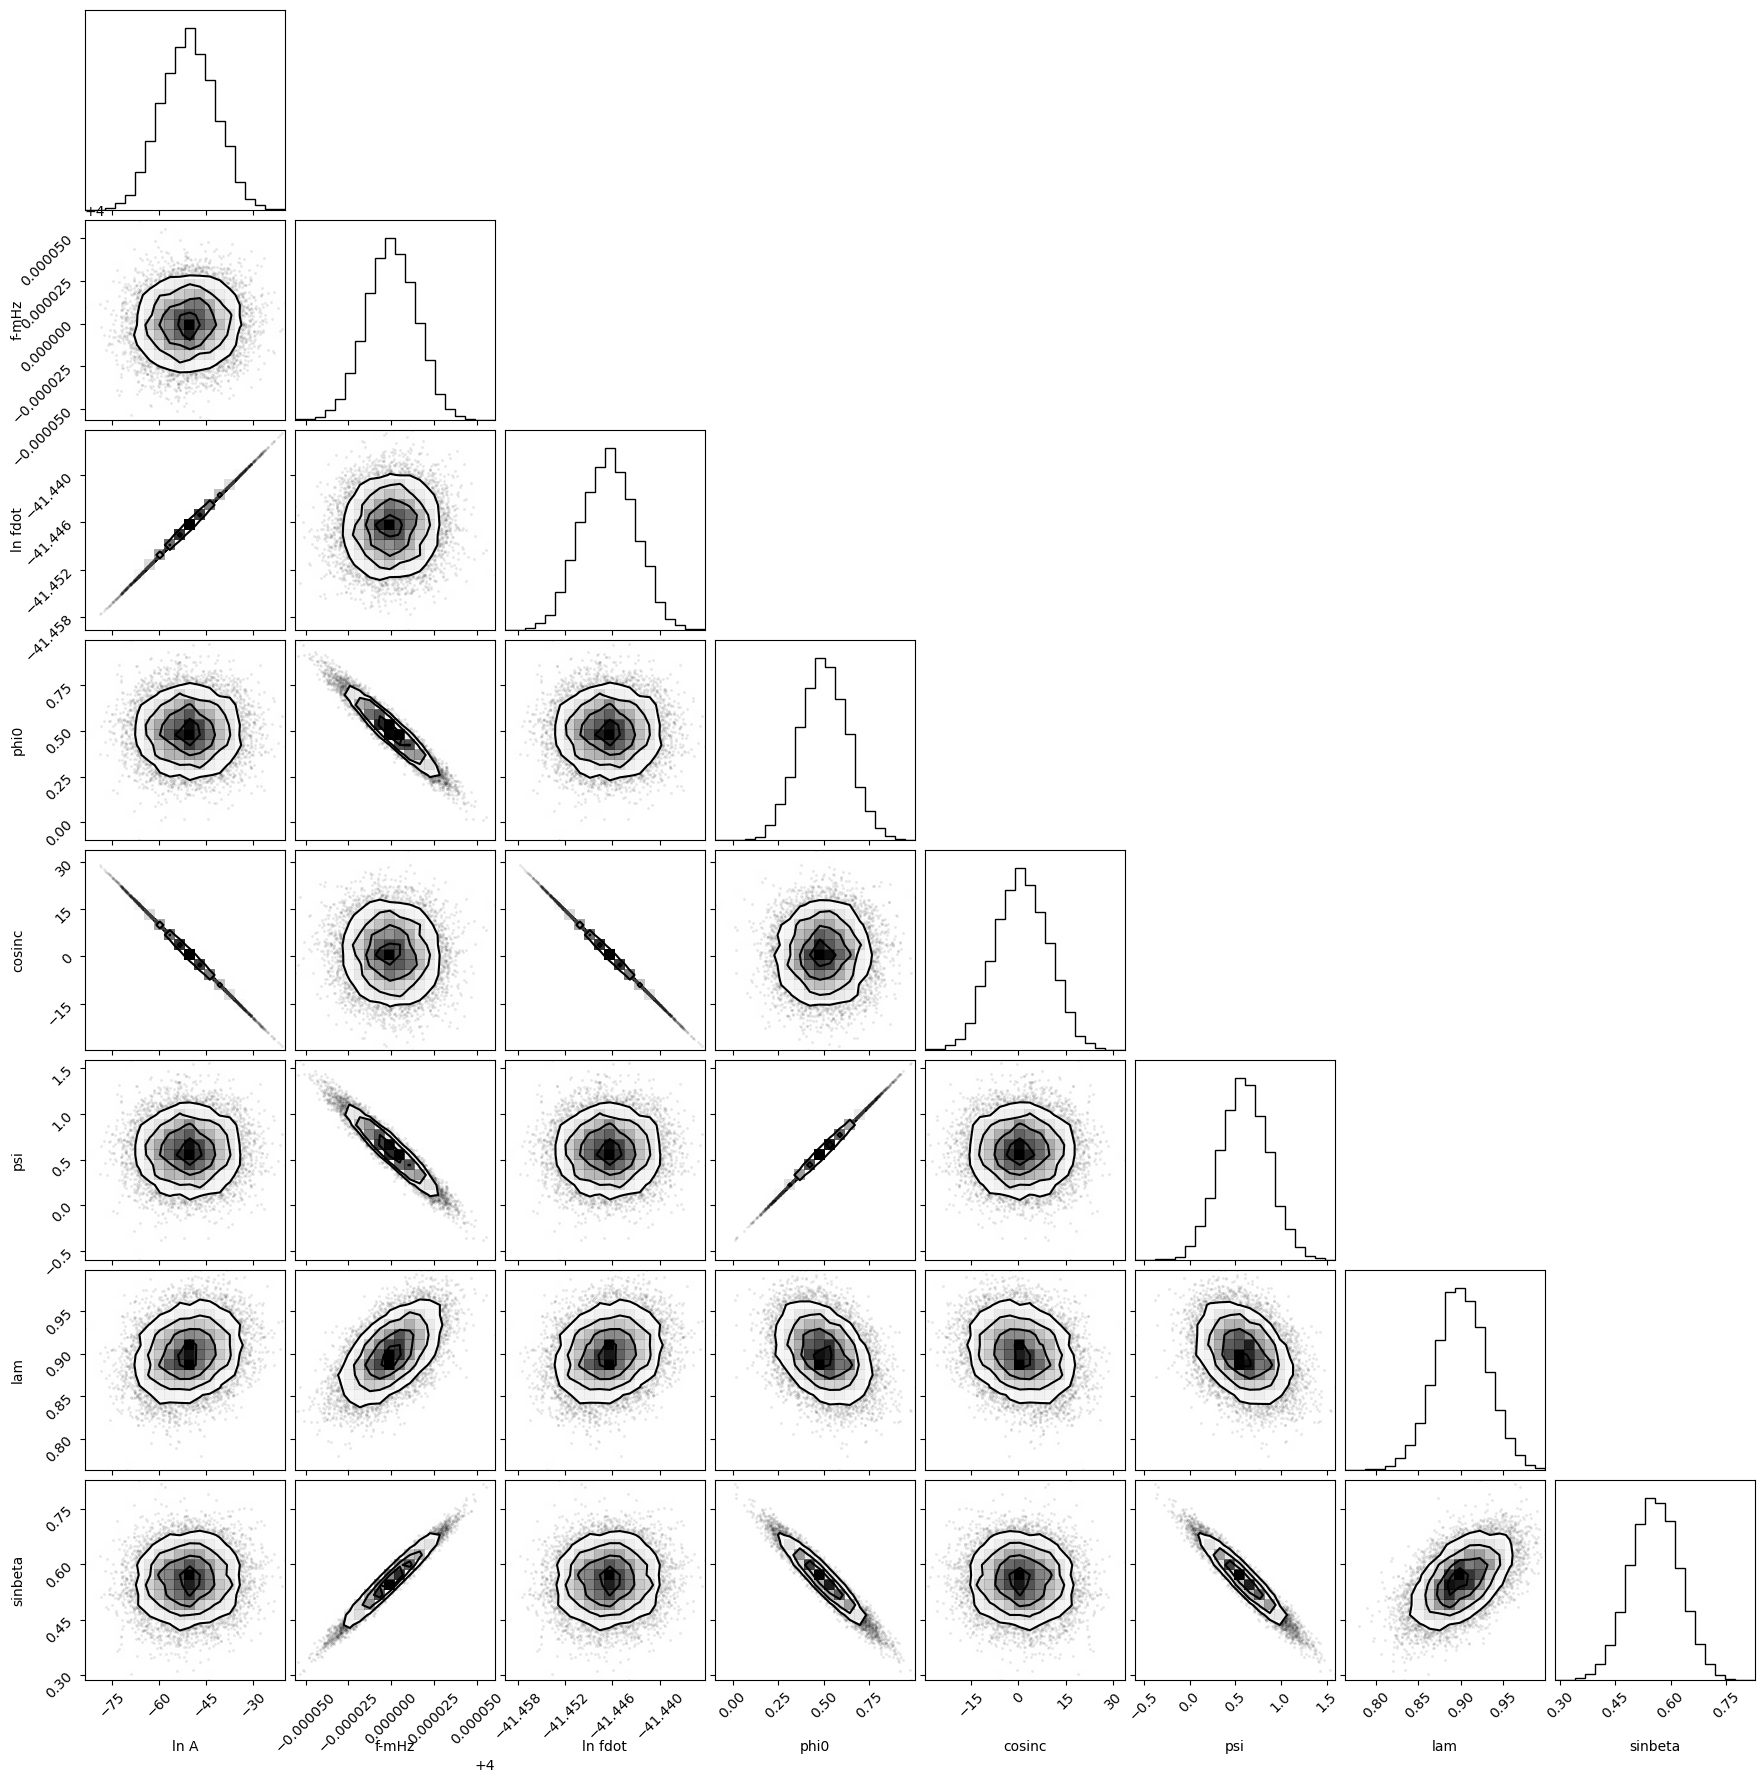

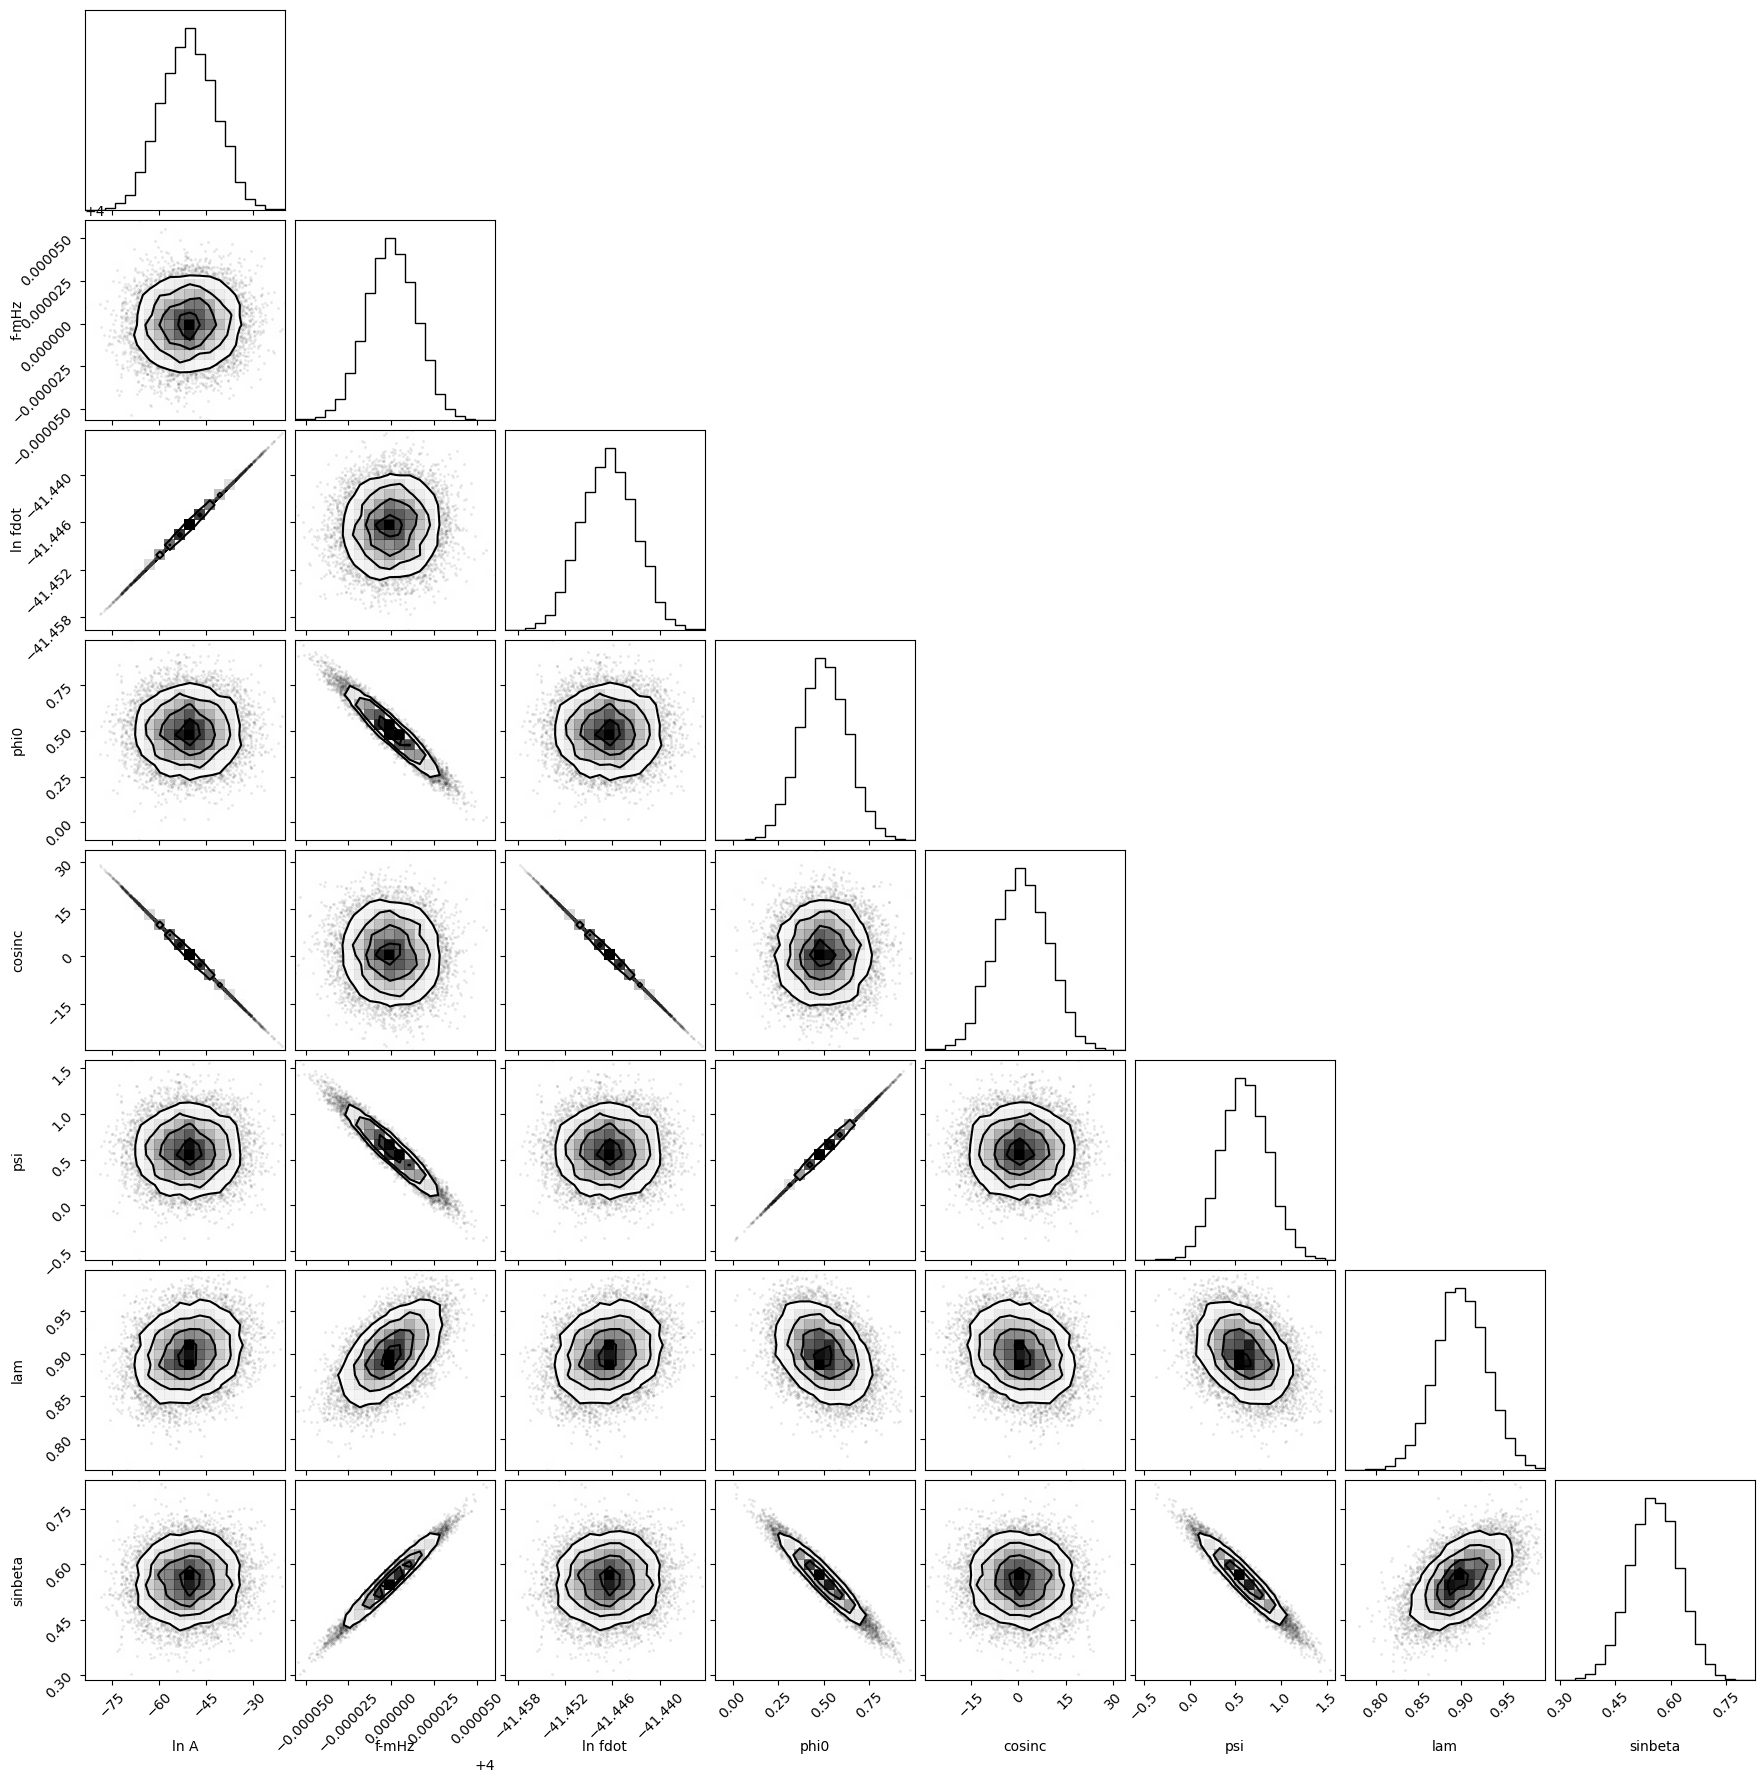

In [12]:
labels=["ln A", "f-mHz", "ln fdot", "phi0", "cosinc", "psi", "lam", "sinbeta"]
plot_covariance_corner(scaled_inj_params, cov, labels=labels, nsamp=10000)

#### VGBs Specifically

In [13]:
vgbs = pd.read_csv("vgbs.txt")

lisa b'HPLib' 8.126391060366705
lisa b'ZTFJ2320' 0.01836013299465549
lisa b'SDSSJ0923' 0.2028434711288258
lisa b'AMCVn' 14.799453128072539
lisa b'CX1751' 0.7309513766094841
lisa b'ZTFJ2029' 0.6274446467730479
lisa b'SDSSJ0935' 7.865112186872143
lisa b'ZTFJ1539' 28.542517280252994
lisa b'SDSSJ2322' 3.6487975261148584
lisa b'4U1820-30' 1.873127538384317
lisa b'HMCnc' 75.27142784882075
lisa b'CRBoo' 2.7687102540460775
lisa b'PTFJ0533' 0.9983470397545212
lisa b'HD265435' 0.06905757674551209
lisa b'CDm30' 0.16438508217450823
lisa b'ZTFJ0640' 0.047898922939256884
lisa b'ZTFJ1749' 0.4075163758763989
lisa b'SMSSJ0338' 0.6767834850994285
lisa b'SDSSJ1630' 0.3426282634464875
lisa b'ZTFJ2055' 0.030491124654783916
lisa b'ZTFJ1901' 0.1563438149712383
lisa b'ZTFJ1946' 0.09091404217486056
lisa b'ESCet' 18.897886059288425
lisa b'SDSSJ1337' 0.131884492895016
lisa b'ZTFJ2130' 0.16830059639947037
lisa b'V407Vul' 23.42031538677392
lisa b'ZTFJ2243' 17.17844611498437
lisa b'SDSSJ0634' 2.7690194331526428
lis

/Users/mlkatz1/miniconda3/envs/test_2050_env/lib/python3.12/site-packages/lisatools/diagnostic.py:376: RuntimeWarning: invalid value encountered in sqrt
  opt_snr = np.sqrt(inner_product(sig1, sig1, *args, **kwargs).real)


lisamax b'ZTFJ0538' nan
lisamax b'SDSSJ0651' 2523.5565766122736
lisamax b'SDSSJ1908' 1060.134527022248
muares b'HPLib' 12264.650849794958
muares b'ZTFJ2320' 4.537607305063294
muares b'SDSSJ0923' 1355.2473235096372
muares b'AMCVn' 57865.258372115015
muares b'CX1751' 579.7317037019859
muares b'ZTFJ2029' 3342.6679040344266
muares b'SDSSJ0935' 7461.604035866067
muares b'ZTFJ1539' 5787.132570563091
muares b'SDSSJ2322' 4110.963459507953
muares b'4U1820-30' 26.25297778502002
muares b'HMCnc' 9617.589692908774
muares b'CRBoo' 53006.86559526818
muares b'PTFJ0533' 2723.270341275061
muares b'HD265435' 29595.71806764496
muares b'CDm30' 1021.977870609326
muares b'ZTFJ0640' 726.6716350778842
muares b'ZTFJ1749' 2898.5790931505985
muares b'SMSSJ0338' 7712.092350449798
muares b'SDSSJ1630' 3572.4977573825777
muares b'ZTFJ2055' 2.0842860849791296
muares b'ZTFJ1901' 1947.468966640149
muares b'ZTFJ1946' 3223.2758745458555
muares b'ESCet' 11066.499644867105
muares b'SDSSJ1337' 120865.69487692969
muares b'ZTF

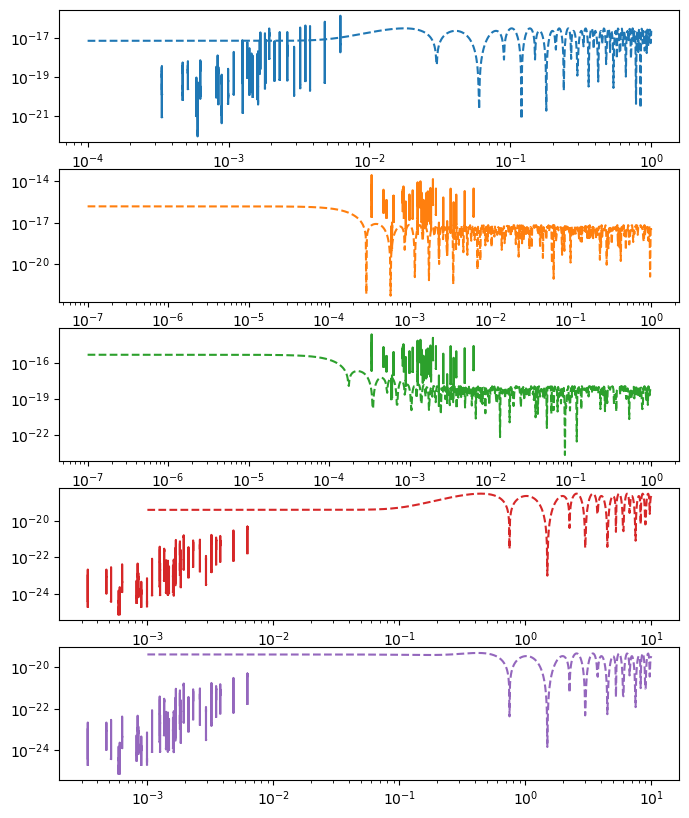

In [14]:
fig, ax = plt.subplots(len(list(missions.keys())), 1, figsize=(8, 2 * len(list(missions.keys()))))
for i, (name, mission) in enumerate(missions.items()):
    fn = mission["model"].fn
    Sn = get_sensitivity(fn, model=mission["model"], sens_fn=A1TDISens, **mission["psd_kwargs"])
    df = get_df(mission["Tobs"], mission["dt"])
    ax[i].loglog(fn, (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")
    for j in range(len(vgbs)):
        vgb = vgbs.iloc[j]
        params_in = np.array([
            vgb["Amplitude"],
            vgb["Frequency"],
            vgb["FrequencyDerivative"],
            0.0,
            vgb["InitialPhase"],
            vgb["Inclination"],
            vgb["Polarization"],
            vgb["EclipticLongitude"],
            vgb["EclipticLatitude"]
        ])
        print(name, vgb["Name"], mission["gb"].get_snr(*params_in, tdi2=True))
        ax[i].loglog(mission["gb"].f_arr, np.abs(mission["gb"].last_output[0]), c=f"C{i}")

### EMRIs

In [15]:
missions["lisa"]["dt"]

10.0

lisa 9.113170729386544
lisamax 2013.3688818793858
muares nan


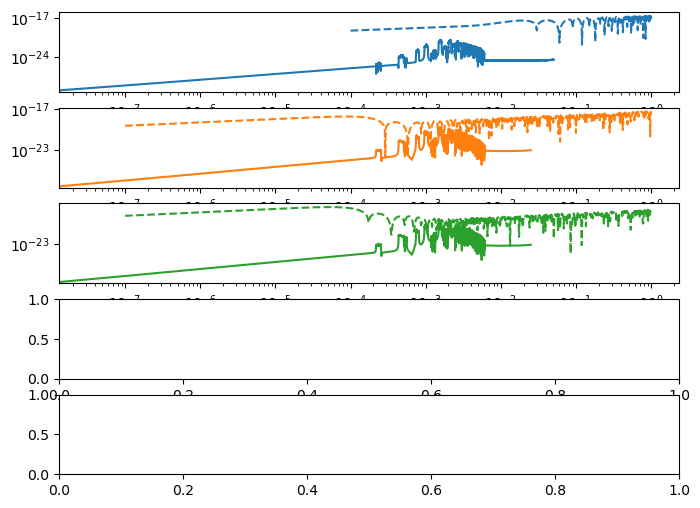

In [16]:
M = 1e6
mu = 1e1
a = 0.2
p0 = 12.0
e0 = 0.2
x0 = 0.1
dist = 3.0
phiS = 0.4423
qS = 0.523023
qK = 0.8923123
phiK = 0.1221209312
Phi_phi0 = 0.1231232
Phi_theta0 = 4.234903824
Phi_r0 = 3.230923

emri_injection_params = np.array(
    [M, mu, a, p0, e0, x0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
)

fig, ax = plt.subplots(len(list(missions.keys())), 1, figsize=(8, 6))

for i, (name, mission) in enumerate(missions.items()):
    # cannot handle decihertz without adjustments. 
    if name in ["deci_cons", "deci_opt"]: 
        continue
    fn = mission["model"].fn
    print(name, mission["emri"].get_snr(*emri_injection_params))
    Sn = get_sensitivity(fn, model=mission["model"], sens_fn=A1TDISens, **mission["psd_kwargs"])
    emri_freqs = np.fft.rfftfreq(mission["emri"].last_output[0].shape[0], mission["emri"].aet_template_gen.dt)
    ax[i].loglog(emri_freqs, emri_freqs * np.abs(np.fft.rfft(mission["emri"].last_output[0])) * mission["emri"].aet_template_gen.dt, c=f"C{i}")
    ax[i].loglog(fn, np.sqrt(fn) * (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")
